<a href="https://colab.research.google.com/github/renatadecassiapires/DHAUZ_DS_2024/blob/main/modelagem_desafio_LH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q7. Previsão de demanda - Produto

# 7.1. Instalações requeridas para o desenvolvimento do projeto

In [1]:
!pip install statsforecast
!pip install hierarchicalforecast

In [2]:
!pip install unidecode

In [3]:
!pip install pandas-gbq

In [4]:
!pip install google-cloud-bigquery

In [59]:
from google.cloud import bigquery

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from unidecode import unidecode
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, HoltWinters

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 7.2. Conexão com BigQuery

In [6]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery

project_id = 'adwsap'

table_id = 'tabela_modelagem_desafio'

client = bigquery.Client(project = project_id)

# 7.3 Visualização dataframe

In [7]:
query = client.query("select * from `adwsap.sap_adw.tabela_modelagem_desafio`")

df = query.to_dataframe()

df.head()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,unitprice,orderqty,revenue_wo_taxandfreight,orderdate,order_status_name,...,productstandardeost,productlistprice,productsize,productweight,productdaystonanufacture,productline,productclass,productstyle,productquantity,productunitprice
0,1145,214,29523,593,15321,4.750000000,26,123.500000000,2011-07-01 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,9922,214,29504,973,18031,4.750000000,32,152.000000000,2012-04-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,10783,348,29734,517,1346,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,10900,348,29692,494,923,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,14472,348,29699,456,10064,14.500000000,11,159.500000000,2012-06-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [8]:
df.shape

(121317, 30)

In [9]:
df.dtypes

id_detalhe_pedido                         Int64
product_fk                                Int64
customerid                                Int64
shiptoadress_fk                           Int64
creditcard_fk                             Int64
unitprice                                object
orderqty                                  Int64
revenue_wo_taxandfreight                 object
orderdate                   datetime64[ns, UTC]
order_status_name                        object
territoryid                               Int64
storename                                object
productid                                 Int64
productsalesid                            Int64
productcompleteid                         Int64
productname                              object
productaakeflag                          object
productfinishedgoodsflag                 object
productsafetystocklevel                  object
productreorderpoint                      object
productstandardeost                     

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   id_detalhe_pedido         121317 non-null  Int64              
 1   product_fk                121317 non-null  Int64              
 2   customerid                121317 non-null  Int64              
 3   shiptoadress_fk           121317 non-null  Int64              
 4   creditcard_fk             118744 non-null  Int64              
 5   unitprice                 121317 non-null  object             
 6   orderqty                  121317 non-null  Int64              
 7   revenue_wo_taxandfreight  121317 non-null  object             
 8   orderdate                 121317 non-null  datetime64[ns, UTC]
 9   order_status_name         121317 non-null  object             
 10  territoryid               87678 non-null   Int64              
 11  

In [11]:
df.describe()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,orderqty,territoryid,productid,productsalesid,productcompleteid
count,121317.0,121317.0,121317.0,121317.0,118744.0,121317.0,87678.0,121317.0,121317.0,121317.0
mean,60659.0,346.680836,24345.630505,5536.210309,9795.943787,2.26608,4.943623,841.680836,841.680836,841.680836
std,35021.345641,86.452124,6689.110387,6121.624676,5639.333551,2.491323,2.712893,86.452124,86.452124,86.452124
min,1.0,212.0,11000.0,9.0,1.0,1.0,1.0,707.0,707.0,707.0
25%,30330.0,273.0,18177.0,756.0,5063.0,1.0,3.0,768.0,768.0,768.0
50%,60659.0,368.0,29485.0,1106.0,10057.0,1.0,4.0,863.0,863.0,863.0
75%,90988.0,426.0,29795.0,10414.0,14814.0,3.0,7.0,921.0,921.0,921.0
max,121317.0,504.0,30118.0,19597.0,19118.0,44.0,10.0,999.0,999.0,999.0


In [12]:
df.describe(include='object').T

,count,unique,top,freq
unitprice,121317,287,4.990000000,8827
revenue_wo_taxandfreight,121317,1468,4.990000000,8827
order_status_name,121317,1,Shipped,121317
storename,28182,528,Twin Cycles,534
productname,121317,266,Water Bottle - 30 oz.,4688
productaakeflag,121317,1,NA,121317
productfinishedgoodsflag,121317,1,NA,121317
productsafetystocklevel,121317,1,NA,121317
productreorderpoint,121317,1,NA,121317
productstandardeost,121317,1,NA,121317


In [13]:
df.isnull().sum()

id_detalhe_pedido               0
product_fk                      0
customerid                      0
shiptoadress_fk                 0
creditcard_fk                2573
unitprice                       0
orderqty                        0
revenue_wo_taxandfreight        0
orderdate                       0
order_status_name               0
territoryid                 33639
storename                   93135
productid                       0
productsalesid                  0
productcompleteid               0
productname                     0
productaakeflag                 0
productfinishedgoodsflag        0
productsafetystocklevel         0
productreorderpoint             0
productstandardeost             0
productlistprice                0
productsize                     0
productweight                   0
productdaystonanufacture        0
productline                     0
productclass                    0
productstyle                    0
productquantity                 0
productunitpri

In [14]:
df.columns

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice'],
      dtype='object')

In [15]:
df['storename'] = df['storename'].fillna('online')

In [16]:
df = df[df['productfinishedgoodsflag'] !=0]

# 7.4 Pré-processamento

In [17]:
df['orderdate'] = pd.to_datetime(df['orderdate'])
df["month"] = pd.to_datetime(df["orderdate"]).dt.to_period('M').dt.to_timestamp()

In [18]:
df['storename'] = df['storename'].str.replace('/', ' ')
df['productname'] = df['productname'].str.replace('/', ' ')
df['productname'] = df['productname'].str.replace('-', ' ')
df['territoryid'] = df['territoryid'].apply(lambda x: unidecode(str(x)))

# 7.5 EDA

In [22]:
# cores

# primárias
cerulean="#0081be"
web_orange="#f7a600"

# secundárias
port_gore="#1a2144"
chambray="#333b8f"
sandal="#9c8b64"
curious_blue="#13a0db"
cornflower="#88bce7"
abbey="#1b1d1e"

# cinzas
neutral_500="#878b97"

In [19]:
monthly_sales = (
    df
    .groupby("month")["orderqty"].sum()
    .reset_index()
)

monthly_sales.head()

,month,orderqty
0,2011-05-01,825
1,2011-06-01,141
2,2011-07-01,2209
3,2011-08-01,2904
4,2011-09-01,157


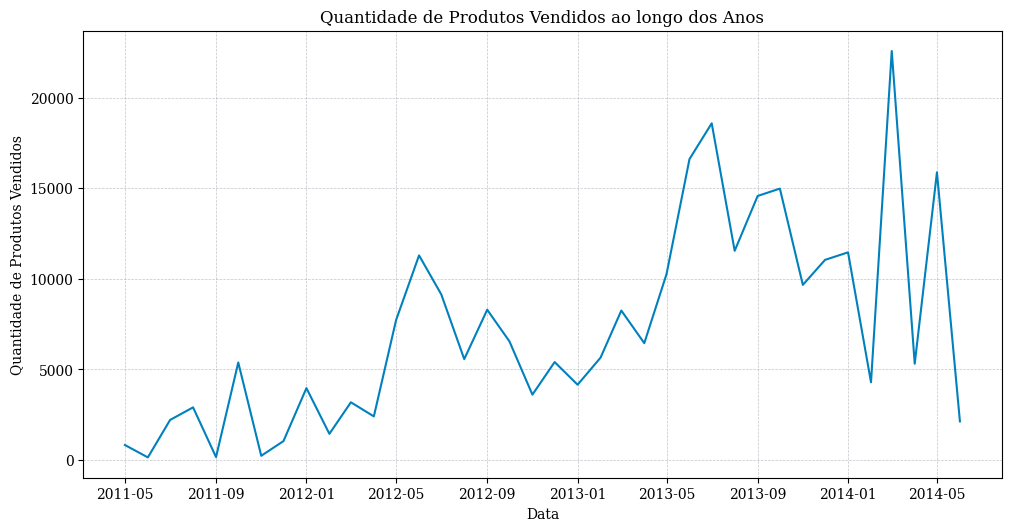

In [23]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = monthly_sales.sort_values('month', ascending=True)

xs = df_sorted['month']
ys = df_sorted['orderqty']

plt.plot(xs, ys, color=cerulean)

plt.title('Quantidade de Produtos Vendidos ao longo dos Anos')
plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')

plt.grid(True, linestyle='--', linewidth=0.5, color=neutral_500, alpha=0.5)

plt.show()

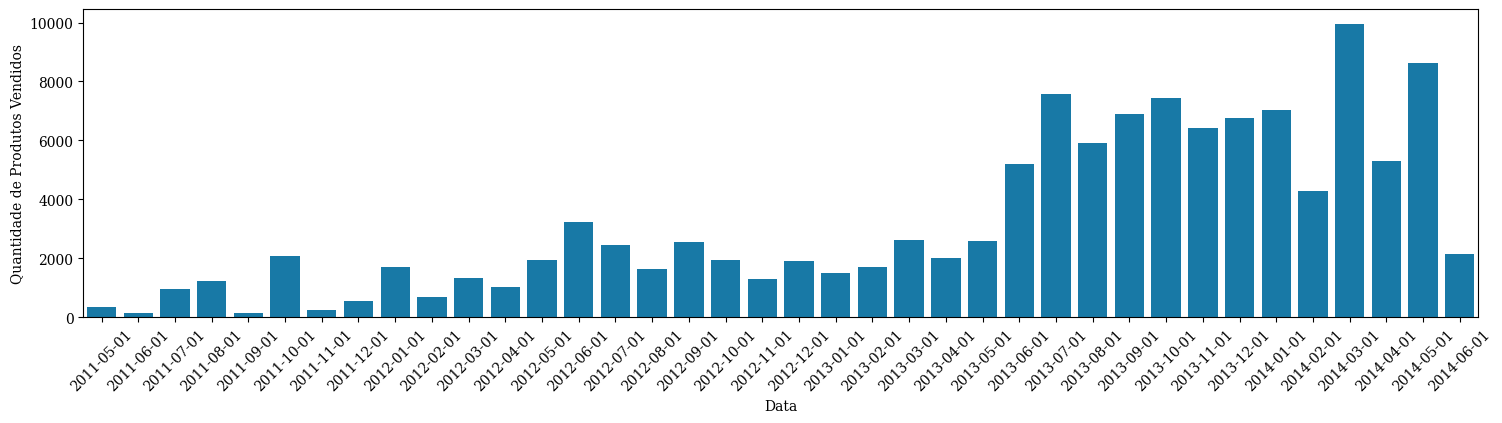

In [25]:
df['month'] = pd.to_datetime(df['month'])
df_sorted = df.sort_values('month')

fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='month', data=df_sorted, color=cerulean)
plt.xticks(rotation=45)

plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()

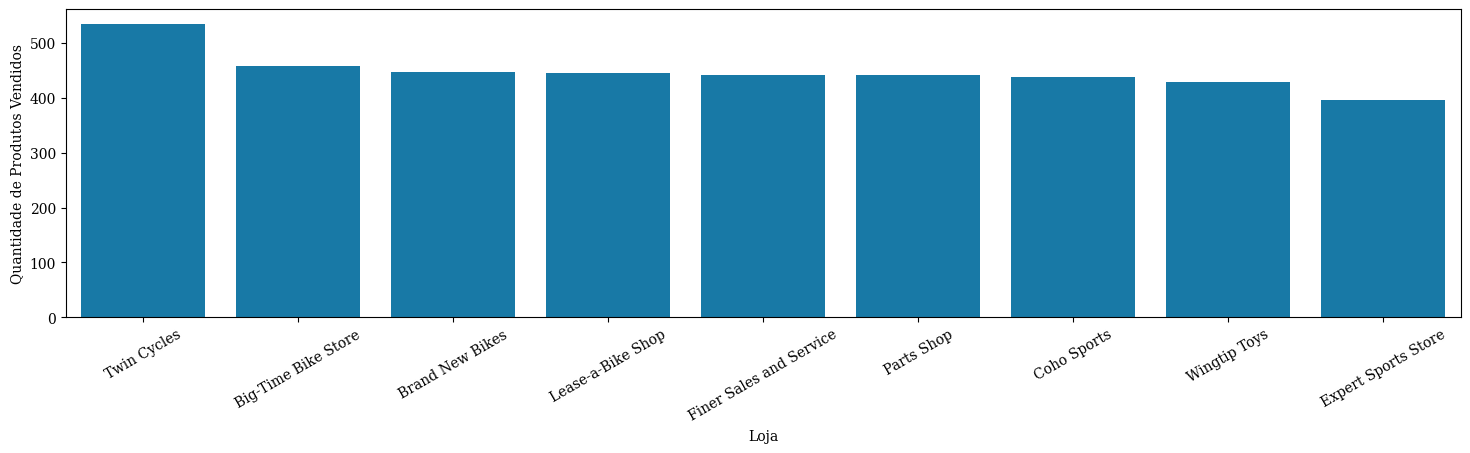

In [26]:
top_10_stores = df['storename'].value_counts().nlargest(10).index
top_10_stores = top_10_stores[1:]
df_top_10_stores = df[df['storename'].isin(top_10_stores)]
df_top_10_stores['storename'] = pd.Categorical(df_top_10_stores['storename'], categories=top_10_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='storename', data=df_top_10_stores, color=cerulean)
plt.xticks(rotation=30)
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()

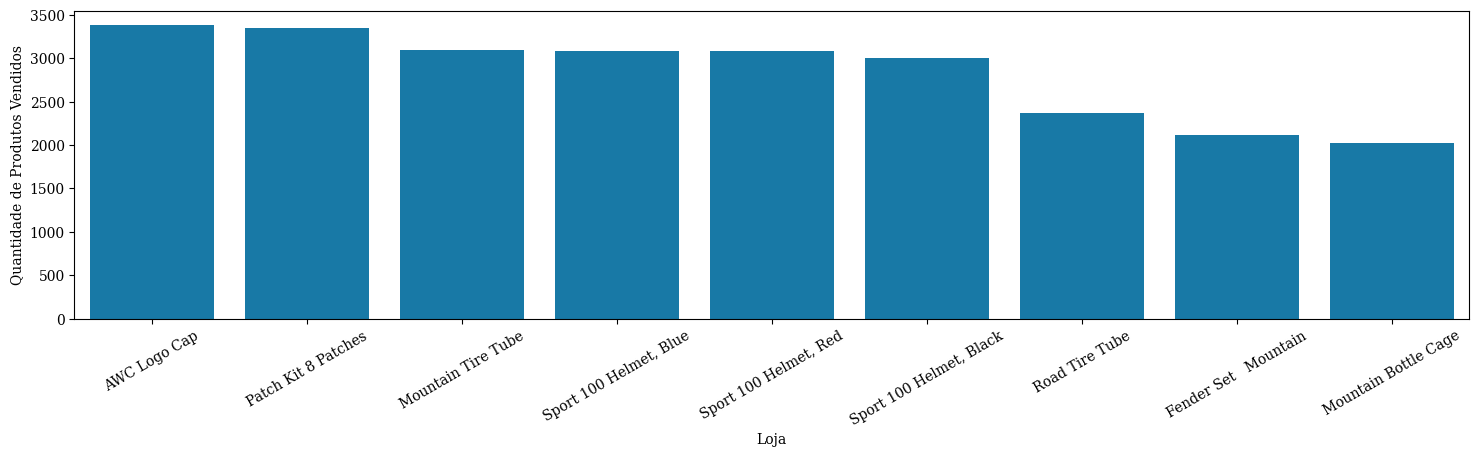

In [27]:
top_stores = df['productname'].value_counts().nlargest(10).index
top_stores = top_stores[1:]
df_top_stores = df[df['productname'].isin(top_stores)]
df_top_stores['productname'] = pd.Categorical(df_top_stores['productname'], categories=top_stores, ordered=True)


fig, axs = plt.subplots(figsize=(18, 4))
ax = sns.countplot(x='productname', data=df_top_stores, color=cerulean)
plt.xticks(rotation=30)
plt.xlabel('Loja')
plt.ylabel('Quantidade de Produtos Vendidos')
plt.show()

# 7.6 Decomposição Sazonal

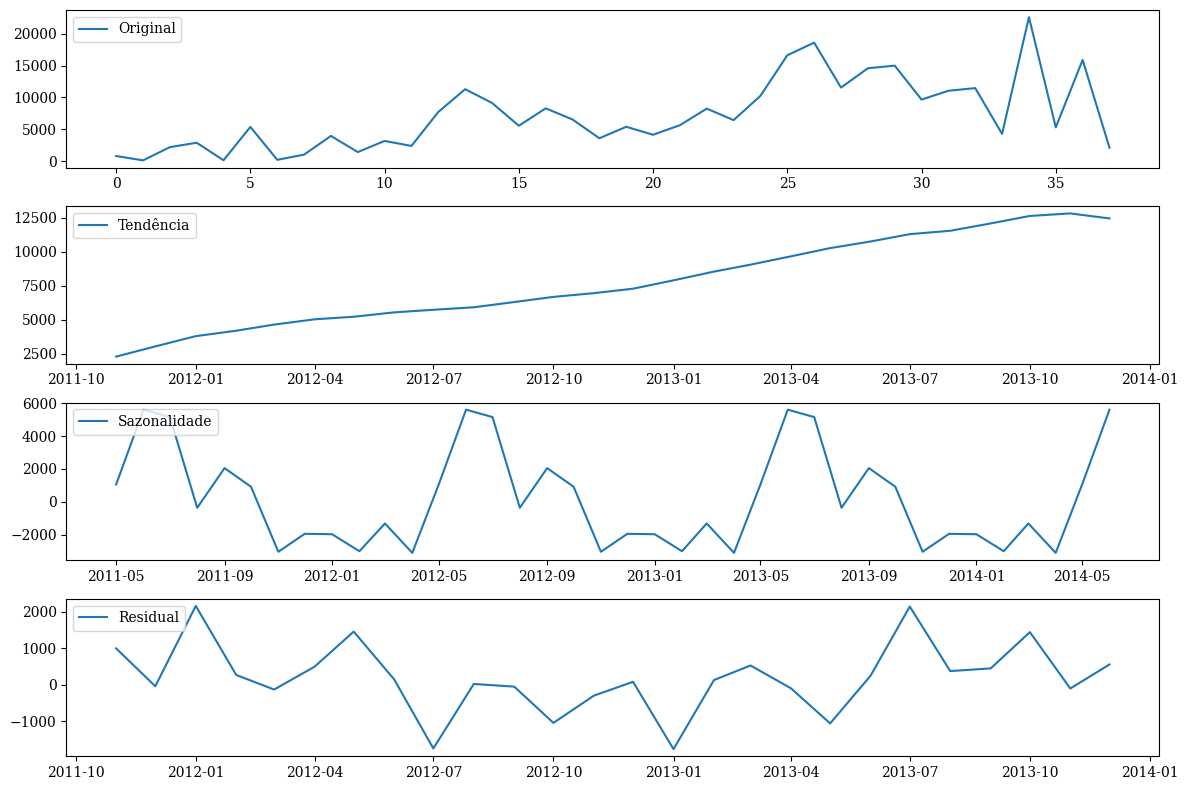

In [28]:
result = seasonal_decompose(monthly_sales.set_index('month')["orderqty"], model='additive', period=12)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition: DecomposeResult):
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['orderqty'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(seasonal_decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal_decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)

# 7.7 Séries hierárquicas

In [29]:
hts = (
    df
    .groupby([
        'month','productname', 'territoryid', 'storename'])["orderqty"].sum()
    .reset_index()
)

hts.head()

,month,productname,territoryid,storename,orderqty
0,2011-05-01,AWC Logo Cap,1,online,5
1,2011-05-01,AWC Logo Cap,2,online,1
2,2011-05-01,AWC Logo Cap,3,Tandem Sales and Service,2
3,2011-05-01,AWC Logo Cap,3,online,2
4,2011-05-01,AWC Logo Cap,4,online,12


In [35]:
general_hierarchies = [
    ['productname'],
    ['territoryid'],
    ['storename'],
    ['territoryid', 'storename'],
    ['territoryid', 'storename', 'productname']
]

In [36]:
hts = hts.rename(columns={"month": "ds", "orderqty": "y"})

In [37]:
print(hts.columns)

Index(['ds', 'productname', 'territoryid', 'storename', 'y'], dtype='object')


In [44]:
result = aggregate(hts, general_hierarchies)
print(f"Número de elementos na tupla: {len(result)}")
for i, item in enumerate(result):
    print(f"Tipo do elemento {i}: {type(item)}")


Número de elementos na tupla: 3
Tipo do elemento 0: <class 'pandas.core.frame.DataFrame'>
Tipo do elemento 1: <class 'pandas.core.frame.DataFrame'>
Tipo do elemento 2: <class 'dict'>


In [45]:
result = aggregate(hts, general_hierarchies)

Y_df = result[0]

Y_df = Y_df.reset_index()

In [46]:
print(Y_df.head())

      unique_id         ds    y
0  AWC Logo Cap 2011-05-01   40
1  AWC Logo Cap 2011-07-01  103
2  AWC Logo Cap 2011-08-01  137
3  AWC Logo Cap 2011-10-01  240
4  AWC Logo Cap 2011-12-01   25


In [47]:
count = Y_df['unique_id'].value_counts()
Y_df = Y_df[Y_df['unique_id'].isin(count[count >= 5].index)]

In [48]:
test_agg = Y_df.groupby('unique_id').tail(3)
train_agg = Y_df.drop(test_agg.index)

print("Conjunto de Teste:")
print(test_agg)
print("\nConjunto de Treinamento:")
print(train_agg)


Conjunto de Teste:
                                    unique_id         ds    y
32                               AWC Logo Cap 2014-04-01  193
33                               AWC Logo Cap 2014-05-01  456
34                               AWC Logo Cap 2014-06-01   93
46                     All Purpose Bike Stand 2014-04-01   23
47                     All Purpose Bike Stand 2014-05-01   13
...                                       ...        ...  ...
58665  <NA>/online/Women's Mountain Shorts, M 2014-05-01   26
58666  <NA>/online/Women's Mountain Shorts, M 2014-06-01   12
58677  <NA>/online/Women's Mountain Shorts, S 2014-04-01   15
58678  <NA>/online/Women's Mountain Shorts, S 2014-05-01   19
58679  <NA>/online/Women's Mountain Shorts, S 2014-06-01   10

[9918 rows x 3 columns]

Conjunto de Treinamento:
                                    unique_id         ds    y
0                                AWC Logo Cap 2011-05-01   40
1                                AWC Logo Cap 2011-07-01  103


# 7.8 Treinamento do modelo

In [49]:
fcst = StatsForecast(
    df=train_agg,
    models=[AutoARIMA(season_length=12), Naive()],
    freq='MS',
)

In [50]:
Y_hat_df = fcst.forecast(h=3)

In [51]:
xmat = test_agg.merge(Y_hat_df, on=['unique_id', 'ds'])
xmat2 = xmat.copy()

# 7.9 Previsão de demanda

In [52]:
xmat_filtrado = (
    xmat.assign(ds=pd.to_datetime(xmat['ds']))
    .loc[xmat['ds'] >= '2014-03-01']
    .sort_values(by='ds', ascending=True)
)

xmat_filtrado.columns = ['Produtos', 'Data', 'Real', 'Previsão', 'Naive']
xmat_filtrado.head(10)


,Produtos,Data,Real,Previsão,Naive
3125,"4/online/Road 550 W Yellow, 38",2014-03-01,20,9.491197,2.0
1483,"1/online/Touring 1000 Yellow, 50",2014-03-01,21,7.904357,12.0
4217,"6/online/Road 350 W Yellow, 44",2014-03-01,1,0.897713,1.0
1485,"1/online/Touring 1000 Yellow, 54",2014-03-01,6,-0.448576,1.0
4215,"6/online/Road 250 Red, 58",2014-03-01,1,1.155845,2.0
1488,"1/online/Touring 1000 Yellow, 60",2014-03-01,27,1.359477,2.0
1492,"1/online/Touring 2000 Blue, 46",2014-03-01,13,7.973603,15.0
1494,"1/online/Touring 2000 Blue, 50",2014-03-01,9,0.000000,2.0
1495,"1/online/Touring 2000 Blue, 54",2014-03-01,22,0.727350,1.0
4183,"6/online/Mountain 200 Silver, 46",2014-03-01,1,2.701199,3.0


In [53]:
print(xmat_filtrado.head())

                              Produtos       Data  Real  Previsão  Naive
3125    4/online/Road 550 W Yellow, 38 2014-03-01    20  9.491197    2.0
1483  1/online/Touring 1000 Yellow, 50 2014-03-01    21  7.904357   12.0
4217    6/online/Road 350 W Yellow, 44 2014-03-01     1  0.897713    1.0
1485  1/online/Touring 1000 Yellow, 54 2014-03-01     6 -0.448576    1.0
4215         6/online/Road 250 Red, 58 2014-03-01     1  1.155845    2.0


In [55]:
def my_rmse(actual, predicted):
    return np.sqrt(((predicted - actual) ** 2).mean())

def my_mse(actual, predicted):
    return ((predicted - actual) ** 2).mean()

def my_mae(actual, predicted):
    return np.abs(predicted - actual).mean()


def creating_results(p_rec_):
    results = []
    for k in p_rec_['Produtos'].unique():
        k_rmse = my_rmse(p_rec_.loc[p_rec_['Produtos'] == k, 'Real'], p_rec_.loc[p_rec_['Produtos'] == k, 'Previsão'])
        k_mse = my_mse(p_rec_.loc[p_rec_['Produtos'] == k, 'Real'], p_rec_.loc[p_rec_['Produtos'] == k, 'Previsão'])
        k_mae = my_mae(p_rec_.loc[p_rec_['Produtos'] == k, 'Real'], p_rec_.loc[p_rec_['Produtos'] == k, 'Previsão'])

        results.append({'Category': k, 'RMSE': k_rmse, 'MSE': k_mse, 'MAE': k_mae})

    results_df = pd.DataFrame(results)
    return results_df

metrics_results = creating_results(xmat_filtrado)

print(metrics_results)


                                      Category        RMSE           MSE  \
0               4/online/Road 550 W Yellow, 38    7.847696     61.586338   
1             1/online/Touring 1000 Yellow, 50    9.772147     95.494861   
2               6/online/Road 350 W Yellow, 44    0.710127      0.504280   
3             1/online/Touring 1000 Yellow, 54    5.214855     27.194710   
4                    6/online/Road 250 Red, 58    0.155845      0.024288   
...                                        ...         ...           ...   
996   10/online/Short Sleeve Classic Jersey, L    0.848383      0.719754   
997                   4/online/Classic Vest, S   27.745042    769.787358   
998                            Classic Vest, M  204.542619  41837.682917   
999                           HL Mountain Tire   40.257504   1620.666667   
1000          10/online/Sport 100 Helmet, Blue    4.966555     24.666667   

             MAE  
0       6.830398  
1       8.755414  
2       0.524313  
3       4.8

In [58]:
mse_autoarima = mean_squared_error(xmat_filtrado['Real'], xmat_filtrado['Previsão'])
rmse_autoarima = np.sqrt(mse_autoarima)
mae_autoarima = mean_absolute_error(xmat_filtrado['Real'], xmat_filtrado['Previsão'])

print("Métricas para o modelo AutoARIMA:")
print("MSE:", mse_autoarima)
print("RMSE:", rmse_autoarima)
print("MAE:", mae_autoarima)

Métricas para o modelo AutoARIMA:
MSE: 127152.90610689047
RMSE: 356.5850615307524
MAE: 45.928860934819006


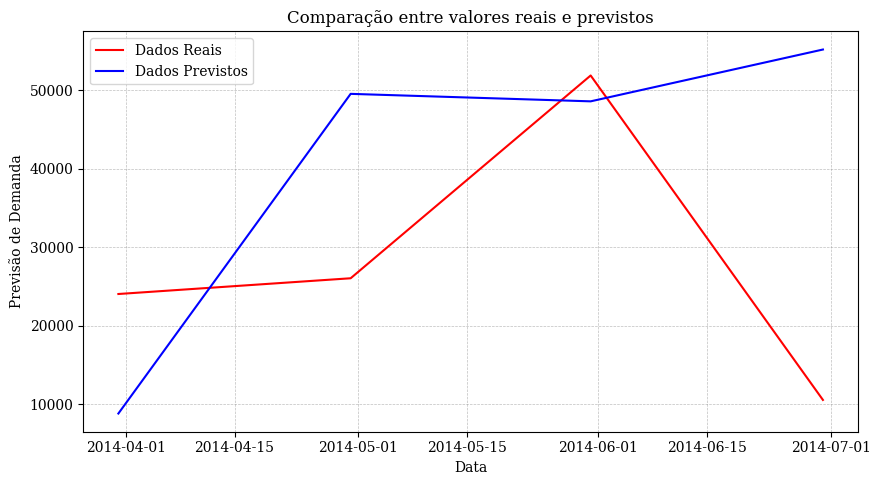

In [61]:
monthly_sales_pred = (
    xmat_filtrado
    .groupby(pd.Grouper(key='Data', freq='M'))['Previsão'].sum()
    .reset_index()
)

monthly_sales_real = (
    xmat_filtrado
    .groupby(pd.Grouper(key='Data', freq='M'))['Real'].sum()
    .reset_index()
)

plt.figure(figsize=(10, 5.2))

plt.plot(monthly_sales_real['Data'], monthly_sales_real['Real'], color='red', label='Dados Reais')
plt.plot(monthly_sales_pred['Data'], monthly_sales_pred['Previsão'], color='blue', label='Dados Previstos')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.title('Comparação entre valores reais e previstos')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.show()


# 7.10 Sazonalidade

In [62]:
Y_hat_df_filtered = xmat2[xmat2['unique_id'].str.contains("AWC Logo Cap")]
Y_hat_df_filtered

,unique_id,ds,y,AutoARIMA,Naive
0,AWC Logo Cap,2014-04-01,193,361.524475,663.0
1,AWC Logo Cap,2014-05-01,456,589.481689,663.0
2,AWC Logo Cap,2014-06-01,93,700.828186,663.0
999,1/Weekend Bike Tours/AWC Logo Cap,2013-04-01,8,3.716773,5.0
1014,1/online/AWC Logo Cap,2014-04-01,18,33.025913,73.0
...,...,...,...,...,...
4885,9/online/AWC Logo Cap,2014-05-01,17,15.190501,17.0
4886,9/online/AWC Logo Cap,2014-06-01,7,14.359314,17.0
5130,<NA>/online/AWC Logo Cap,2014-04-01,102,100.000000,100.0
5131,<NA>/online/AWC Logo Cap,2014-05-01,143,100.000000,100.0


In [63]:
Y_hat_df_filtered.head()


,unique_id,ds,y,AutoARIMA,Naive
0,AWC Logo Cap,2014-04-01,193,361.524475,663.0
1,AWC Logo Cap,2014-05-01,456,589.481689,663.0
2,AWC Logo Cap,2014-06-01,93,700.828186,663.0
999,1/Weekend Bike Tours/AWC Logo Cap,2013-04-01,8,3.716773,5.0
1014,1/online/AWC Logo Cap,2014-04-01,18,33.025913,73.0


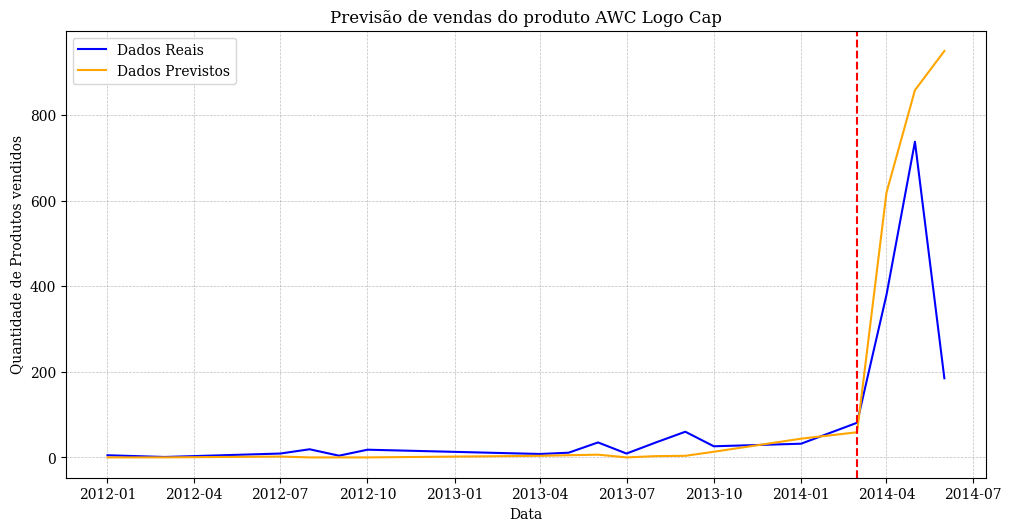

In [75]:
monthly_sales_pred = (
    Y_hat_df_filtered
    .groupby("ds")["AutoARIMA"].sum()
    .reset_index()
)

monthly_sales_y = (
    Y_hat_df_filtered
    .groupby("ds")["y"].sum()
    .reset_index()
)

# O restante do código para plotagem permanece o mesmo
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

df_sorted_pred = monthly_sales_pred.sort_values('ds', ascending=True)
df_sorted_y = monthly_sales_y.sort_values('ds', ascending=True)

xs_pred = df_sorted_pred['ds']
ys_pred = df_sorted_pred['AutoARIMA']  # Substituído 'pred' por 'AutoARIMA'

xs_y = df_sorted_y['ds']
ys_y = df_sorted_y['y']

plt.plot(xs_y, ys_y, color='blue', label='Dados Reais')  # Substitua 'blue' pelo código de cor exato para cerulean
plt.plot(xs_pred, ys_pred, color='orange', label='Dados Previstos')  # Substitua 'orange' pelo código de cor exato para web_orange

date_to_plot = pd.to_datetime('2014-03-01')
plt.axvline(x=date_to_plot, color='red', linestyle='--')

plt.title('Previsão de vendas do produto AWC Logo Cap')
plt.xlabel('Data')
plt.ylabel('Quantidade de Produtos vendidos')

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.5)  # Substitua 'grey' pelo código de cor exato para neutral_500

plt.show()

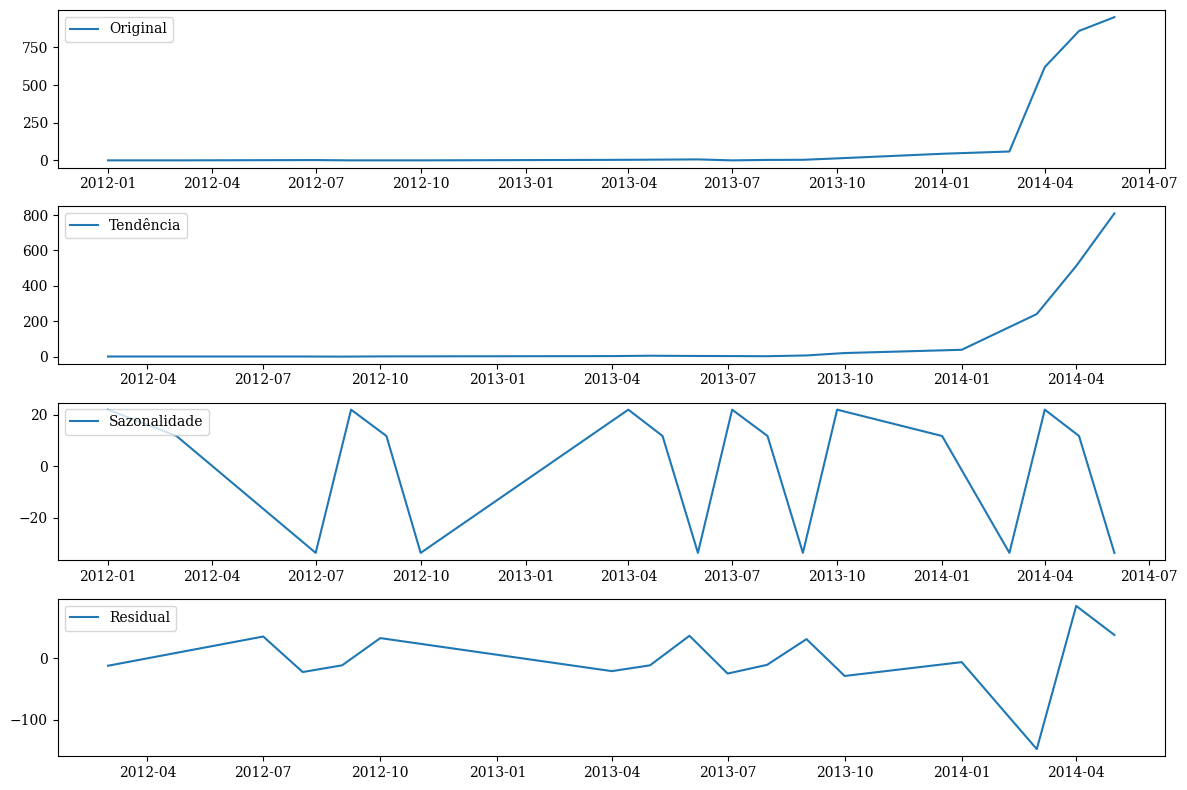

In [76]:
monthly_sales = (
    Y_hat_df_filtered
    .groupby("ds")["AutoARIMA"].sum()
    .reset_index()
)

result = seasonal_decompose(monthly_sales.set_index('ds')["AutoARIMA"], model='additive', period=3)

def seasonal_decomposition_plots(data: pd.DataFrame, seasonal_decomposition):

    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data['ds'], data['AutoARIMA'], label='Original')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(data['ds'], seasonal_decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(data['ds'], seasonal_decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(data['ds'], seasonal_decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()

    return plt.show()

seasonal_decomposition_plots(data=monthly_sales, seasonal_decomposition=result)


# Q.8 Regressão linear

# 8.1 Pré-processamento

> Bloco com recuo



In [77]:
df2 = df.copy()
df2.head()

,id_detalhe_pedido,product_fk,customerid,shiptoadress_fk,creditcard_fk,unitprice,orderqty,revenue_wo_taxandfreight,orderdate,order_status_name,...,productlistprice,productsize,productweight,productdaystonanufacture,productline,productclass,productstyle,productquantity,productunitprice,month
0,1145,214,29523,593,15321,4.750000000,26,123.500000000,2011-07-01 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2011-07-01
1,9922,214,29504,973,18031,4.750000000,32,152.000000000,2012-04-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-04-01
2,10783,348,29734,517,1346,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-05-01
3,10900,348,29692,494,923,14.500000000,11,159.500000000,2012-05-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-05-01
4,14472,348,29699,456,10064,14.500000000,11,159.500000000,2012-06-30 00:00:00+00:00,Shipped,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,2012-06-01


In [84]:
df2.columns

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'month'],
      dtype='object')

In [85]:
hts = (
    df2
    .groupby([
        'month', 'productname', 'territoryid',
        'storename'])['unitprice', 'orderqty', 'revenue_wo_taxandfreight',
                       'productsafetystocklevel', 'productreorderpoint',
                       'productstandardeost', 'productlistprice',
                       'productsize', 'productweight', 'productdaystonanufacture',
                       'productline', 'productclass', 'productstyle', 'productquantity',
                       'productunitprice'].sum().reset_index()
)

hts.head()


,month,productname,territoryid,storename,orderqty
0,2011-05-01,AWC Logo Cap,1,online,5
1,2011-05-01,AWC Logo Cap,2,online,1
2,2011-05-01,AWC Logo Cap,3,Tandem Sales and Service,2
3,2011-05-01,AWC Logo Cap,3,online,2
4,2011-05-01,AWC Logo Cap,4,online,12


In [81]:
hts = hts.set_index('month')
hts.index = pd.to_datetime(hts.index)

# 8.2 Feature Engineering

In [80]:
def concatenar_valores(row):
    return '/'.join(row)

hts['concat'] = hts[['productname', 'territoryid', 'storename']].apply(concatenar_valores, axis=1)
hts.head()

,month,productname,territoryid,storename,orderqty,concat
0,2011-05-01,AWC Logo Cap,1,online,5,AWC Logo Cap/1/online
1,2011-05-01,AWC Logo Cap,2,online,1,AWC Logo Cap/2/online
2,2011-05-01,AWC Logo Cap,3,Tandem Sales and Service,2,AWC Logo Cap/3/Tandem Sales and Service
3,2011-05-01,AWC Logo Cap,3,online,2,AWC Logo Cap/3/online
4,2011-05-01,AWC Logo Cap,4,online,12,AWC Logo Cap/4/online


In [88]:
print(hts2.columns)

Index(['productname', 'territoryid', 'storename', 'orderqty'], dtype='object')


In [89]:
hts['concat'] = hts['productname'] + hts['territoryid'].astype(str) + hts['storename']

In [91]:
hts2 = hts.drop('concat', axis=1)
df_valores_concatenados = hts.loc[:, ['concat']]

In [92]:
label_encoder = LabelEncoder()
hts2['storename'] = label_encoder.fit_transform(hts2['storename'])
hts2['productname'] = label_encoder.fit_transform(hts2['productname'])
hts2['territoryid'] = label_encoder.fit_transform(hts2['territoryid'])

df_concat = hts2.copy()

In [94]:
# modelagem

In [93]:
hts2

,month,productname,territoryid,storename,orderqty
0,2011-05-01,0,0,528,5
1,2011-05-01,0,2,528,1
2,2011-05-01,0,3,452,2
3,2011-05-01,0,3,528,2
4,2011-05-01,0,4,528,12
...,...,...,...,...,...
49518,2014-06-01,262,4,528,1
49519,2014-06-01,262,7,528,1
49520,2014-06-01,262,8,528,1
49521,2014-06-01,262,9,528,2


# 8.3 Treinamento Xgboost

In [95]:
train = df2.loc[df2['month'] < '2014-04-01']
test = df2.loc[df2['month'] >= '2014-04-01']

features = ['unitprice', 'revenue_wo_taxandfreight', 'productsafetystocklevel',
            'productreorderpoint', 'productstandardeost', 'productlistprice',
            'productsize', 'productweight', 'productdaystonanufacture',
            'productline', 'productclass', 'productstyle', 'productquantity',
            'productunitprice', 'storename', 'territoryid', 'productname']

target = 'orderqty'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [100]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        try:
            X_train[col] = X_train[col].astype(float)
        except ValueError:
            le = LabelEncoder()
            X_train[col] = le.fit_transform(X_train[col])

In [109]:
print('storename' in X_train.columns)

True


In [110]:
for key in label_encoders.keys():
    print(key)

In [111]:
label_encoders = {}
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].fillna('Missing'))
        label_encoders[col] = le

for col in X_test.columns:
    if col in label_encoders:
        X_test[col] = label_encoders[col].transform(X_test[col].fillna('Missing'))
    else:
        try:
            X_test[col] = X_test[col].astype(float)
        except ValueError:
            pass

In [113]:
for col in ['storename', 'territoryid', 'productname']:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

In [118]:
for col in ['storename', 'territoryid', 'productname']:
    if X_train[col].dtype == 'object' or X_test[col].dtype == 'object':
        le = LabelEncoder()
        # Combine o treino e o teste para o ajuste do encoder para garantir a cobertura de todas as categorias
        le.fit(list(X_train[col].fillna('Missing')) + list(X_test[col].fillna('Missing')))
        X_train[col] = le.transform(X_train[col].fillna('Missing'))
        X_test[col] = le.transform(X_test[col].fillna('Missing'))

In [119]:
print(X_train.dtypes)
print(X_test.dtypes)

unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel     float64
productreorderpoint         float64
productstandardeost         float64
productlistprice            float64
productsize                 float64
productweight               float64
productdaystonanufacture    float64
productline                 float64
productclass                float64
productstyle                float64
productquantity             float64
productunitprice            float64
storename                     int64
territoryid                   int64
productname                   int64
dtype: object
unitprice                   float64
revenue_wo_taxandfreight    float64
productsafetystocklevel     float64
productreorderpoint         float64
productstandardeost         float64
productlistprice            float64
productsize                 float64
productweight               float64
productdaystonanufacture    float64
productline                 float64
productclass  

In [120]:
reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True
)

[0]	validation_0-rmse:1.73238
[1]	validation_0-rmse:1.64314
[2]	validation_0-rmse:1.54927
[3]	validation_0-rmse:1.46960
[4]	validation_0-rmse:1.38674
[5]	validation_0-rmse:1.31327
[6]	validation_0-rmse:1.25370
[7]	validation_0-rmse:1.19685
[8]	validation_0-rmse:1.16747
[9]	validation_0-rmse:1.11639
[10]	validation_0-rmse:1.09329
[11]	validation_0-rmse:1.04277
[12]	validation_0-rmse:1.02389
[13]	validation_0-rmse:1.00141
[14]	validation_0-rmse:0.95513
[15]	validation_0-rmse:0.93962
[16]	validation_0-rmse:0.90323
[17]	validation_0-rmse:0.88167
[18]	validation_0-rmse:0.86963
[19]	validation_0-rmse:0.83493
[20]	validation_0-rmse:0.82586
[21]	validation_0-rmse:0.79552
[22]	validation_0-rmse:0.78375
[23]	validation_0-rmse:0.76650
[24]	validation_0-rmse:0.75545
[25]	validation_0-rmse:0.72839
[26]	validation_0-rmse:0.72124
[27]	validation_0-rmse:0.69768
[28]	validation_0-rmse:0.68980
[29]	validation_0-rmse:0.67866
[30]	validation_0-rmse:0.67365
[31]	validation_0-rmse:0.64631
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# 8.4 Métricas de avaliação

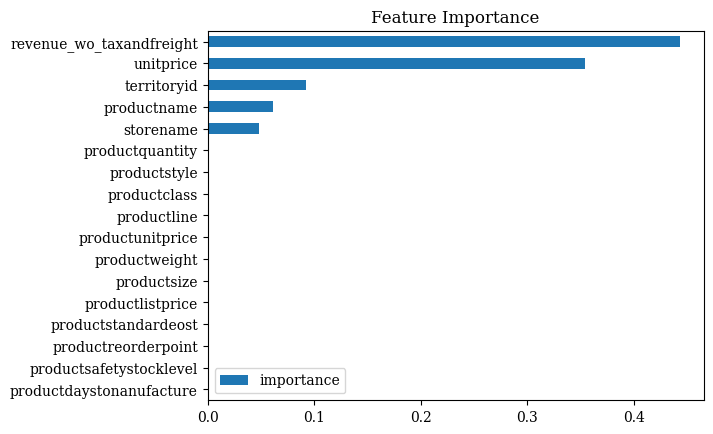

In [121]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [122]:
test['prediction'] = reg.predict(X_test)
test['prediction'].reset_index()

,index,prediction
0,563,1.050531
1,564,1.050531
2,565,1.050531
3,566,1.050531
4,567,1.050531
...,...,...
16053,118014,1.204073
16054,118015,4.007358
16055,118016,4.007358
16056,118017,3.203305


In [123]:
df1 = hts2.copy()
df1['prediction'] = pd.Series([float('NaN')] * len(df1), index=df1.index)

In [126]:
print(len(test['prediction'].values))

df1.iloc[-len(test['prediction'].values):, df1.columns.get_loc('prediction')] = test['prediction'].values

16058


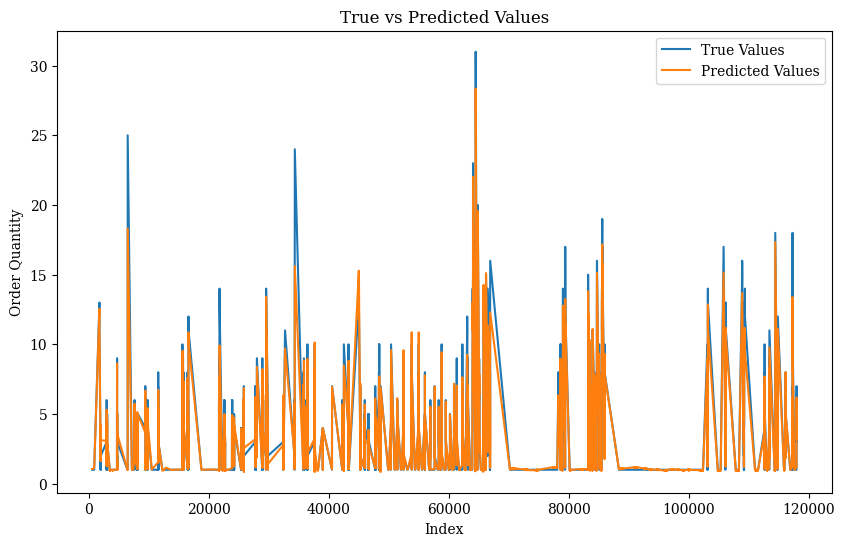

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(test['orderqty'], label='True Values')
plt.plot(test['prediction'], label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Order Quantity')
plt.legend()
plt.show()

In [130]:
def my_rmse(x,y):
    return np.round(np.sqrt(mse(x.values,y.values)), 2)

def my_mse(x, y):
    return np.round(mse(x.values, y.values), 2)

def my_mae(x, y):
    return np.round(np.nanmean(abs(x.values -  y.values)), 2)

k_rmse = my_rmse(test['orderqty'], test['prediction'])
k_mse = my_mse(test['orderqty'], test['prediction'])
k_mae = my_mae(test['orderqty'], test['prediction'])

results_xgboost = {'RMSE': [k_rmse], 'MSE': [k_mse], 'MAE': [k_mae]}
results_df_xgboost = pd.DataFrame(results_xgboost)
results_df_xgboost

,RMSE,MSE,MAE
0,0.24,0.06,0.1


In [132]:
metrics_results = creating_results(xmat_filtrado)
df_resultado_metricas = pd.concat([metrics_results, results_df_xgboost], ignore_index=True)
df_resultado_metricas = df_resultado_metricas.rename(index={0: 'ARIMA', 1: 'XGBoost'})

styled_df = df_resultado_metricas.style.set_caption('Resultados das Métricas').background_gradient(cmap='Blues')

styled_df


,Category,RMSE,MSE,MAE
ARIMA,"4/online/Road 550 W Yellow, 38",7.850000,61.590000,6.830000
XGBoost,"1/online/Touring 1000 Yellow, 50",9.770000,95.490000,8.760000
2,"6/online/Road 350 W Yellow, 44",0.710000,0.500000,0.520000
3,"1/online/Touring 1000 Yellow, 54",5.210000,27.190000,4.820000
4,"6/online/Road 250 Red, 58",0.160000,0.020000,0.160000
5,"1/online/Touring 1000 Yellow, 60",21.650000,468.890000,17.700000
6,"1/online/Touring 2000 Blue, 46",5.030000,25.260000,5.030000
7,"1/online/Touring 2000 Blue, 50",9.000000,81.000000,9.000000
8,"1/online/Touring 2000 Blue, 54",15.610000,243.580000,13.120000
9,"6/online/Mountain 200 Silver, 46",1.120000,1.250000,0.980000


In [133]:
df_concat['produto/pais/loja'] = df_valores_concatenados['concat']

In [134]:
df_concat

,month,productname,territoryid,storename,orderqty,produto/pais/loja
0,2011-05-01,0,0,528,5,AWC Logo Cap1online
1,2011-05-01,0,2,528,1,AWC Logo Cap2online
2,2011-05-01,0,3,452,2,AWC Logo Cap3Tandem Sales and Service
3,2011-05-01,0,3,528,2,AWC Logo Cap3online
4,2011-05-01,0,4,528,12,AWC Logo Cap4online
...,...,...,...,...,...,...
49518,2014-06-01,262,4,528,1,"Women's Mountain Shorts, S4online"
49519,2014-06-01,262,7,528,1,"Women's Mountain Shorts, S7online"
49520,2014-06-01,262,8,528,1,"Women's Mountain Shorts, S8online"
49521,2014-06-01,262,9,528,2,"Women's Mountain Shorts, S9online"


In [136]:
print(df.columns)

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'month'],
      dtype='object')


In [138]:
df_concat['prediction'] = pd.Series([float('NaN')] * len(df_concat), index=df_concat.index)

In [141]:
prediction_length = len(test['prediction'].values)

num_rows = min(prediction_length, len(df_concat))

df_concat.iloc[-num_rows:, df_concat.columns.get_loc('prediction')] = test['prediction'].values[:num_rows]

In [142]:
df_concat

,month,productname,territoryid,storename,orderqty,produto/pais/loja,prediction
0,2011-05-01,0,0,528,5,AWC Logo Cap1online,NaN
1,2011-05-01,0,2,528,1,AWC Logo Cap2online,NaN
2,2011-05-01,0,3,452,2,AWC Logo Cap3Tandem Sales and Service,NaN
3,2011-05-01,0,3,528,2,AWC Logo Cap3online,NaN
4,2011-05-01,0,4,528,12,AWC Logo Cap4online,NaN
...,...,...,...,...,...,...,...
49518,2014-06-01,262,4,528,1,"Women's Mountain Shorts, S4online",1.204073
49519,2014-06-01,262,7,528,1,"Women's Mountain Shorts, S7online",4.007358
49520,2014-06-01,262,8,528,1,"Women's Mountain Shorts, S8online",4.007358
49521,2014-06-01,262,9,528,2,"Women's Mountain Shorts, S9online",3.203305


In [143]:
print(df.columns)

Index(['id_detalhe_pedido', 'product_fk', 'customerid', 'shiptoadress_fk',
       'creditcard_fk', 'unitprice', 'orderqty', 'revenue_wo_taxandfreight',
       'orderdate', 'order_status_name', 'territoryid', 'storename',
       'productid', 'productsalesid', 'productcompleteid', 'productname',
       'productaakeflag', 'productfinishedgoodsflag',
       'productsafetystocklevel', 'productreorderpoint', 'productstandardeost',
       'productlistprice', 'productsize', 'productweight',
       'productdaystonanufacture', 'productline', 'productclass',
       'productstyle', 'productquantity', 'productunitprice', 'month'],
      dtype='object')


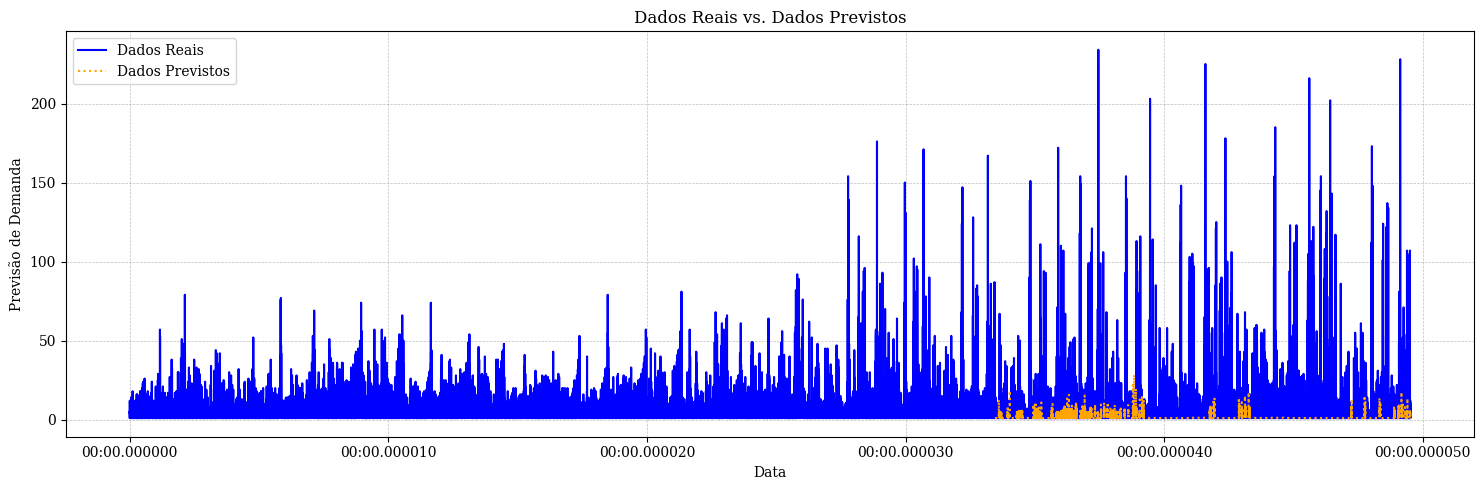

In [148]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(df_concat.index, df_concat['orderqty'], color='blue', label='Dados Reais')

plt.plot(df_concat.index, df_concat['prediction'], color='orange', linestyle='dotted', label='Dados Previstos')

plt.xlabel('Data')
plt.ylabel('Previsão de Demanda')
plt.title('Dados Reais vs. Dados Previstos')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


# Q9. Previsão de demanda - País

In [155]:
df_concat

,month,productname,territoryid,storename,orderqty,produto/pais/loja,prediction
1970-01-01 00:00:00.000000000,2011-05-01,0,0,528,5,AWC Logo Cap1online,NaN
1970-01-01 00:00:00.000000001,2011-05-01,0,2,528,1,AWC Logo Cap2online,NaN
1970-01-01 00:00:00.000000002,2011-05-01,0,3,452,2,AWC Logo Cap3Tandem Sales and Service,NaN
1970-01-01 00:00:00.000000003,2011-05-01,0,3,528,2,AWC Logo Cap3online,NaN
1970-01-01 00:00:00.000000004,2011-05-01,0,4,528,12,AWC Logo Cap4online,NaN
...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000049518,2014-06-01,262,4,528,1,"Women's Mountain Shorts, S4online",1.204073
1970-01-01 00:00:00.000049519,2014-06-01,262,7,528,1,"Women's Mountain Shorts, S7online",4.007358
1970-01-01 00:00:00.000049520,2014-06-01,262,8,528,1,"Women's Mountain Shorts, S8online",4.007358
1970-01-01 00:00:00.000049521,2014-06-01,262,9,528,2,"Women's Mountain Shorts, S9online",3.203305


In [156]:
df_concat['local'] = 'Resto do Mundo'
df_concat.loc[df_concat['territoryid'] == 0, 'local'] = 'EUA'

In [157]:
demanda_anterior = '2014-04-01'
demanda_prevista = '2014-06-30'
df_selected = df_concat[(df_concat['month'] >= demanda_anterior) & (df_concat['month'] <= demanda_prevista)]

In [158]:
demanda_usa = df_selected[df_selected['local'] == 'EUA']['orderqty'].sum()
demanda_resto_mundo = df_selected[df_selected['local'] == 'Resto do Mundo']['orderqty'].sum()

In [159]:
if demanda_usa > demanda_resto_mundo:
    print("Os EUA apresentaram mais crescimento na demanda nos três meses previstos.")
elif demanda_usa < demanda_resto_mundo:
    print("O Resto do Mundo apresentou mais crescimento na demanda nos três meses previstos.")
else:
    print("Os EUA e o Resto do Mundo tiveram o mesmo crescimento na demanda nos três meses previstos.")

O Resto do Mundo apresentou mais crescimento na demanda nos três meses previstos.


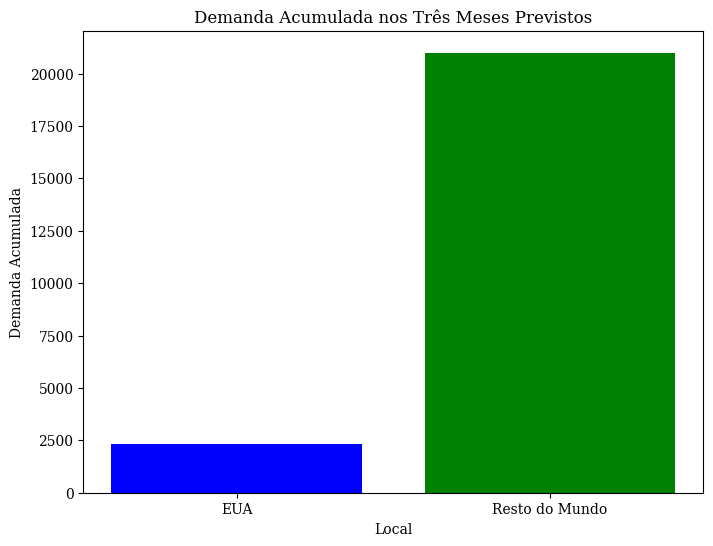

In [160]:
locais = ['EUA', 'Resto do Mundo']
demandas = [demanda_usa, demanda_resto_mundo]

plt.figure(figsize=(8, 6))
plt.bar(locais, demandas, color=['blue', 'green'])
plt.xlabel('Local')
plt.ylabel('Demanda Acumulada')
plt.title('Demanda Acumulada nos Três Meses Previstos')
plt.show()

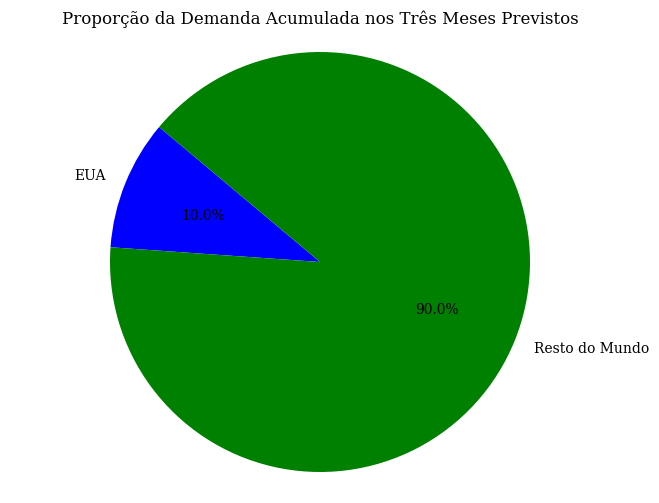

In [161]:
locais = ['EUA', 'Resto do Mundo']
demandas = [demanda_usa, demanda_resto_mundo]

plt.figure(figsize=(8, 6))
plt.pie(demandas, labels=locais, autopct='%1.1f%%', colors=['blue', 'green'], startangle=140)
plt.title('Proporção da Demanda Acumulada nos Três Meses Previstos')
plt.axis('equal')
plt.show()

# Q10. Previsão demanda de zíper

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, Naive, SeasonalNaive

In [ ]:
sf = StatsForecast(
    df=Y_train_df,
    models=[AutoETS(season_length=12), Naive(), SeasonalNaive(season_length=12), ], #AutoARIMA(season_length=12),
    freq="MS",
)

In [ ]:
Y_hat_df = sf.forecast(h=7, fitted=True)

In [ ]:
Y_hat_df.head()

In [ ]:
Y_train_df['ds'] = pd.to_datetime(Y_train_df['ds'], errors='coerce')

# Drop any rows where 'ds' is NaT (not a time) after conversion
Y_train_df = Y_train_df.dropna(subset=['ds'])

# Exclude non-numeric columns from the fitting process
# Assuming that 'unique_id' could serve as the id_col and 'ds' as the time_col
sf.fit(Y_train_df[['ds', 'territoryid', 'y', 'unique_id', 'storename_encoded', 'y_numeric']])

predictions = sf.predict(h=12, level=0.95)


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive

sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'MS'
)
sf.fit(Y_train_df)
predictions = sf.predict(h=12, level=0.95)

Y_train_df["y"] = Y_train_df["y"].astype(float)
predictions['AutoARIMA'] = predictions['AutoARIMA'].astype('float64')

In [ ]:
unique_storenames = Y_train_df['storename'].unique()
print("Valores únicos na coluna 'storename':", unique_storenames)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

Y_train_df['storename_encoded'] = label_encoder.fit_transform(Y_train_df['storename'])

unique_storename_encoded = Y_train_df['storename_encoded'].unique()
print("Valores únicos na coluna 'storename_encoded':", unique_storename_encoded)


In [ ]:
import pandas as pd

Y_train_df['y_numeric'] = pd.to_numeric(Y_train_df['y'], errors='coerce')

nan_values = Y_train_df['y_numeric'].isna().sum()

if nan_values > 0:
    print("Existem", nan_values, "valores não numéricos na coluna 'y'.")
    print(Y_train_df[Y_train_df['y_numeric'].isna()])
else:
    print("Não há valores não numéricos na coluna 'y'.")


In [ ]:
y_value_counts = Y_train_df['y'].apply(type).value_counts()

print("Tipos de dados na coluna 'y':")
print(y_value_counts)


In [ ]:
!pip install pmdarima

In [ ]:
!pip install sktime

In [ ]:
import numpy as np

class NaiveModel:
    def __init__(self):
        pass

    def fit(self, y):
        pass

    def forecast(self, horizon):
        return np.repeat(y[-1], horizon)


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive

sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'MS'
)
sf.fit(y_train_df)
predictions = sf.predict(h=12, level=0.95)

y_train_df["y"] = y_train_df["y"].astype(float)
predictions['AutoARIMA'] = predictions['AutoARIMA'].astype('float32')


In [ ]:
from statsforecast import StatsForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.forecasting.naive import NaiveForecaster

sf = StatsForecast(
    df=Y_train_df,
    models=[
        ExponentialSmoothing(endog=Y_train_df['y'], trend='add', seasonal='add', seasonal_periods=12),
        NaiveForecaster(strategy="last"),
        SARIMAX(endog=Y_train_df['y'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
        auto_arima(Y_train_df['y'], seasonal=True, m=12)
    ],
    freq="MS",  # Frequência dos dados temporais (mensal, no caso)
    id_col="unique_id",  # Nome da coluna que identifica cada série temporal
    time_col="ds",  # Nome da coluna que contém as datas
    target_col="y",  # Nome da coluna que contém os valores a serem previstos
)


In [ ]:
# Importar a classe StatsForecast
from statsforecast import StatsForecast

# Criar o objeto StatsForecast com os modelos desejados
sf = StatsForecast(
    df=Y_train_df,
    models=[AutoETS(season_length=12), Naive(), SeasonalNaive(season_length=12)],
    freq="MS"
)

# Treinar o modelo
sf.fit()


In [ ]:
from statsforecast import StatsForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Supondo que você já tenha dividido os dados em conjuntos de treinamento e teste
# Supondo também que complete_df_filtered contém os dados filtrados sem a coluna 'unique_id'
y_train = Y_train_df['y']

# Criar o objeto StatsForecast com os modelos desejados
fcst = StatsForecast(
    df=complete_df_filtered,
    models=[
        ExponentialSmoothing(endog=y_train, trend='add', seasonal='add', seasonal_periods=12),
        ARIMA(endog=y_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
    ],
    freq='MS'
)

# Treinar o modelo
fcst.fit()

# Fazer previsões para os próximos períodos
y_hat_train = fcst.forecast(h=3)  # Previsões para os próximos 3 períodos


In [ ]:
display(Y_hat_train)
display(Y_hat_train2)

In [ ]:
# Certifique-se de que 'y_train' seja convertido para um tipo de dados numérico
y_train = pd.to_numeric(y_train, errors='coerce')

# Criar o objeto StatsForecast com os modelos desejados
fcst = StatsForecast(
    df=complete_df_filtered,
    models=[
        ExponentialSmoothing(endog=y_train, trend='add', seasonal='add', seasonal_periods=12),
        ARIMA(endog=y_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
    ],
    freq='MS'
)


In [ ]:
# Converter a coluna "y" para o tipo de dados numérico
Y_train_df["y"] = pd.to_numeric(Y_train_df["y"], errors='coerce')

In [ ]:
print(Y_train_df[Y_train_df['y'].apply(lambda x: not isinstance(x, (int, float)))])


In [ ]:
print(Y_train_df.isnull().sum())

In [ ]:
from utilsforecast import StatsForecast, AutoARIMA
import pandas as pd
import numpy as np

# Check the contents and data types of your training data
print(Y_train_df.head())
print(Y_train_df.dtypes)

# Example of preprocessing steps you might need to perform
# Remove or preprocess columns containing non-numeric values
# Y_train_df = Y_train_df.drop(columns=['column_with_non_numeric_data'])

# Initialize and fit the StatsForecast model
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS'
)

# Fit the model to the training data
sf.fit(Y_train_df)

# Generate predictions
predictions = sf.predict(h=12, level=[95])
print(predictions)


In [ ]:
sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'MS'
)

sf.fit(Y_train_df)

(predictions := sf.predict(h=12, level=[95]))

In [ ]:
# Importar as bibliotecas necessárias
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import numpy as np

# Criar uma instância do StatsForecast
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],  # Usar o modelo AutoARIMA com sazonalidade mensal
    freq="MS"  # Frequência dos dados: mensal
)

# Converter apenas a coluna 'y' para o tipo float
Y_train_df["y"] = Y_train_df["y"].astype(float)

# Treinar o modelo com os dados de treinamento
sf.fit(Y_train_df)

# Fazer previsões para os próximos 12 meses
predictions = sf.predict(h=12, level=[95])

# Converter o tipo de dados da coluna 'y' das previsões para float32
predictions['AutoARIMA'] = predictions['AutoARIMA'].astype('float32')

# Agora você pode avaliar as previsões e fazer ajustes conforme necessário


In [ ]:
# Agrupe os dados por produto, loja e mês e some as vendas
monthly_sales = (
    grouped_data
    .groupby(["productid", "storename", "month"])["sales"]
    .sum()
    .reset_index()
)

# Visualize os dados agrupados
print(monthly_sales.head())


In [ ]:
# Converta a coluna de data para o formato de data
ts["month"] = pd.to_datetime(ts["date"]).dt.to_period('M').dt.to_timestamp()

# Agrupe os dados por produto, loja e mês e some as vendas
monthly_sales = (
    ts
    .groupby(["productid", "storename", "month"])["sales"]
    .sum()
    .reset_index()
)

# Visualize os dados agrupados
print(monthly_sales.head())

# Contar o número de produtos distintos
num_products = monthly_sales["productid"].nunique()
print("Número de produtos distintos:", num_products)


In [ ]:
# Convertendo a coluna 'ds' para timestamps
Y_train_df['ds'] = pd.to_datetime(Y_train_df['ds'])

# Convertendo a coluna 'ds' para inteiros (se os dados são períodos mensais)
Y_train_df['ds'] = Y_train_df['ds'].dt.to_timestamp().values.astype(np.int64) // 10 ** 9


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Criação do modelo StatsForecast com AutoARIMA
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS'  # Frequência dos dados (mensal)
)

# Treinamento do modelo com os dados de treinamento
sf.fit(Y_train_df)

# Fazendo previsões para os próximos 12 meses
predictions = sf.predict(h=12, level=[95])

# Ajustando os tipos de dados das colunas 'y' nos dados de treinamento e previsões
Y_train_df["y"] = Y_train_df["y"].astype(float)
predictions['AutoARIMA'] = predictions['AutoARIMA'].astype(float)


In [ ]:
# não mexer - outras tentativas

import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Renomear a coluna 'month' para 'ds' e converter para datetime
specific_product_data['ds'] = pd.to_datetime(specific_product_data['month'])

# Remover linhas com valores ausentes, se necessário
specific_product_data.dropna(inplace=True)

# Filtrar dados irrelevantes ou duplicados, se necessário
# specific_product_data = specific_product_data[condição de filtro]

# Criar o modelo StatsForecast com AutoARIMA
sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS')

# Dividir dados em treino e teste
Y_test_df = specific_product_data.tail(3)
Y_train_df = specific_product_data.drop(Y_test_df.index)

# Treinar o modelo com os dados de treinamento
sf.fit(Y_train_df)

# Fazer previsões para os próximos 3 meses
predictions = sf.predict(h=3, level=[95])

# Calcular métricas para as previsões
mae = mean_absolute_error(Y_test_df['y'], predictions['AutoARIMA'])
mse = mean_squared_error(Y_test_df['y'], predictions['AutoARIMA'])

print("Métricas para AutoARIMA:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

# Visualizar as previsões
print("Previsões do modelo AutoARIMA:")
print(predictions['AutoARIMA'])


In [ ]:
specific_product_data['unique_id'] = "total"

specific_product_data = specific_product_data.rename(columns={'month': 'ds', 'orderqty': 'y', 'revenue_wo_taxandfreight': 'sales'})


In [ ]:
specific_product_data.head()

In [ ]:
print(specific_product_data.columns)


In [ ]:
specific_product_data_monthly = specific_product_data.groupby('ds').agg({'y': 'sum'}).reset_index()

In [ ]:
Y_test_df = specific_product_data.tail(3)
Y_train_df = specific_product_data.drop(Y_test_df.index)

print(f"dados de treino - pegar o último mês: {Y_train_df['ds'].max()}")
print(f"dados de teste - primeiro: {Y_test_df['ds'].min()}, último: {Y_test_df['ds'].max()}")

In [ ]:
import matplotlib.pyplot as plt

specific_product_data_monthly['ds'] = specific_product_data_monthly['ds'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(specific_product_data_monthly['ds'], specific_product_data_monthly['y'], marker='o', color='b')
plt.title('Total de vendas por mês')
plt.xlabel('Mês')
plt.ylabel('Total de vendas')
plt.grid(True)
plt.show()


In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

autoarima_model = auto_arima(specific_product_data_monthly['y'], seasonal=True, m=12)

In [ ]:
# Definir o tamanho dos dados de treinamento e teste
train_size = int(len(specific_product_data_monthly) * 0.8)
test_size = len(specific_product_data_monthly) - train_size

# Dividir os dados em treinamento e teste
train_data = specific_product_data_monthly.iloc[:train_size]
test_data = specific_product_data_monthly.iloc[train_size:]


In [ ]:
# Treinar o modelo AutoARIMA com os dados de treinamento
autoarima_model.fit(train_data['y'])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fazer previsões para os próximos meses
forecast = autoarima_model.predict(n_periods=len(test_data))

In [ ]:
# Definir o tamanho dos dados de treinamento e teste
train_size = int(len(specific_product_data_monthly) * 0.8)
test_size = len(specific_product_data_monthly) - train_size

# Dividir os dados em treinamento e teste
train_data = specific_product_data_monthly.iloc[:train_size]
test_data = specific_product_data_monthly.iloc[train_size:]

# Treinar o modelo AutoARIMA com os dados de treinamento
autoarima_model.fit(train_data['y'])

# Fazer previsões para os próximos meses
forecast = autoarima_model.predict(n_periods=test_size)

# Calcular métricas de avaliação
mae = mean_absolute_error(test_data['y'], forecast)
mse = mean_squared_error(test_data['y'], forecast)

print(f'MAE: {mae}')
print(f'MSE: {mse}')


In [ ]:
Y_train_specific_product_data['ds'] = pd.to_datetime(Y_train_specific_product_data['month'])

In [ ]:

Y_train_specific_product_data['ds'] = pd.to_datetime(Y_train_specific_product_data['month'])

# Verifique se as datas foram adicionadas corretamente
print(Y_train_df.head())



Y_test_df = specific_product_data.tail(3)
Y_train_df = specific_product_data.drop(Y_test_df.index)

print(f"dados de treino - pegar o último mês: {Y_train_df['ds'].max()}")
print(f"dados de teste - primeiro: {Y_test_df['ds'].min()}, último: {Y_test_df['ds'].max()}")

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Criação do modelo StatsForecast com AutoARIMA
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS'  # Frequência dos dados (mensal)
)

# Treinamento do modelo com os dados de treinamento
sf.fit(Y_train_df)

# Fazendo previsões para os próximos 2 meses
predictions = sf.predict(h=2, level=[95])

# Visualizando as previsões
predictions

In [ ]:
autoarima_model = auto_arima(Y_train_df['y'], seasonal=True, m=12)

Y_hat_train1 = autoarima_model.predict(n_periods=3)

naive_model = Y_train_df['y'].iloc[-1]  # último valor observado
Y_hat_train2 = [naive_model] * 3  # repetir o último valor observado 3 vezes

mae_autoarima = mean_absolute_error(Y_test_df['y'], Y_hat_train1)
mse_autoarima = mean_squared_error(Y_test_df['y'], Y_hat_train1)

mae_naive = mean_absolute_error(Y_test_df['y'], Y_hat_train2)
mse_naive = mean_squared_error(Y_test_df['y'], Y_hat_train2)

print("Métricas para AutoARIMA:")
print(f"MAE: {mae_autoarima}")
print(f"MSE: {mse_autoarima}")

print("\nMétricas para Naive:")
print(f"MAE: {mae_naive}")
print(f"MSE: {mse_naive}")


In [ ]:
print("Previsões do modelo AutoARIMA:")
print(Y_hat_train1)

print("Previsões do modelo Naive:")
print(Y_hat_train2)


In [ ]:
# feature engineering

In [ ]:
print(grouped_data.columns)

In [ ]:
# data ['month'] = data['month'].dt.to_timestamp(how = 'start').dt.date
# data['productstyle'] = data['productstyle'].replace('Universal', 'U').str.strip()
# data[]

In [ ]:
display(offline_sales)[]